In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
device

device(type='cuda')

In [5]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset

block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP Revisited
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the mlp

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/ ((n_embd * block_size)**0.5) # kaimin init
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,W2,b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
    p.to(device)

12097


In [8]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
epsilon = 1e-5

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 # + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True) 
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  + bnbias + epsilon # batch normalization
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # mostly the original + a little of the new one
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # mostly the original + a little of the new one
    
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # Loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5676
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8898
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2919
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6413
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1708


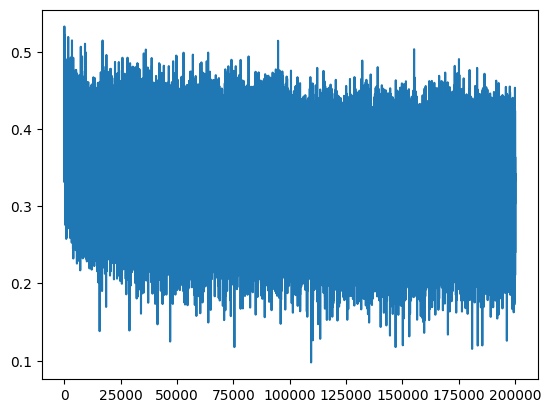

In [9]:
plt.plot(lossi);

In [10]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

NameError: name 'b1' is not defined

In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x] #(N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into  (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

In [ ]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all . . .
    while True:
        #forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        #sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        #if we sample the special'.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) #decode and printe the generated word

In [34]:
# Let's train a deeper network

from typing import Any


class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in,fan_out), generator=g) / fan_in**0.5 #sqrt of fan_in
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    
    def parameters(self):
        return [self.weight] +([] if self.bias is None else [self.bias])
    
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffer(trained with running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self,x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)     # bacth mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # the dimensionalityo f the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),               generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    #last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
        

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [40]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed the charaters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # Loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEB?UG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([((lr*p.grad).std()/p.data.std()).log10().item() for p in parameters])
    
    if i > 1000:
        break # AFTER_DEBUG: would take out obviously

      0/ 200000: 2.2269
  10000/ 200000: 1.8825
  20000/ 200000: 2.2567
  30000/ 200000: 2.0585
  40000/ 200000: 2.1647
  50000/ 200000: 2.0637
  60000/ 200000: 2.0198
  70000/ 200000: 1.9352
  80000/ 200000: 2.2173
  90000/ 200000: 2.2596
 100000/ 200000: 2.2751
 110000/ 200000: 1.9971
 120000/ 200000: 2.1551
 130000/ 200000: 2.1451


KeyboardInterrupt: 

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.97%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.22%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.25%


Text(0.5, 1.0, 'activation distribution')

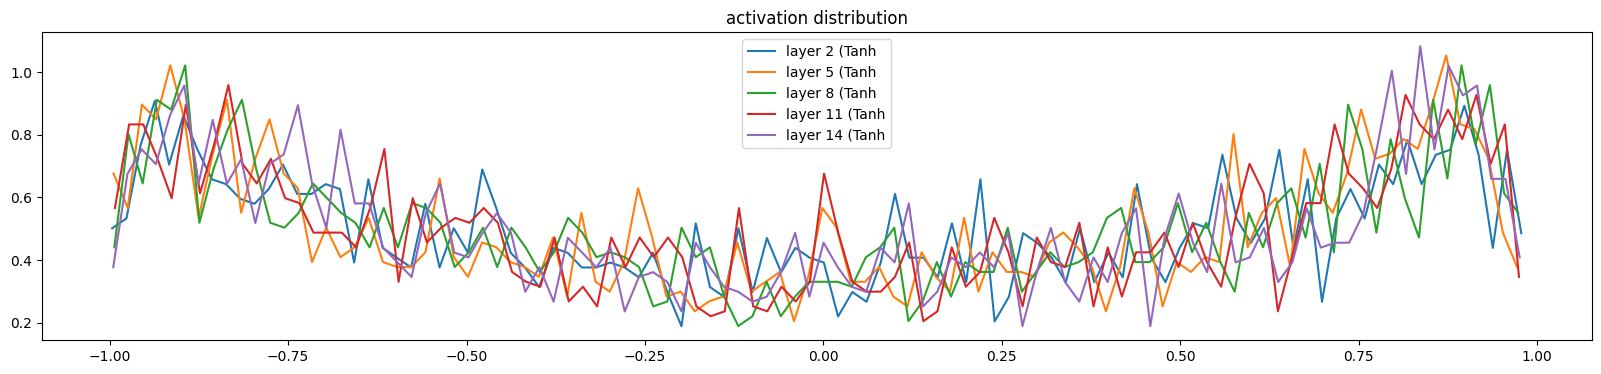

In [36]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.561979e-03
layer 5 (      Tanh): mean -0.000000, std 3.119525e-03
layer 8 (      Tanh): mean -0.000000, std 2.904406e-03
layer 11 (      Tanh): mean -0.000000, std 2.580224e-03
layer 14 (      Tanh): mean -0.000000, std 2.440871e-03


Text(0.5, 1.0, 'gradient distribution')

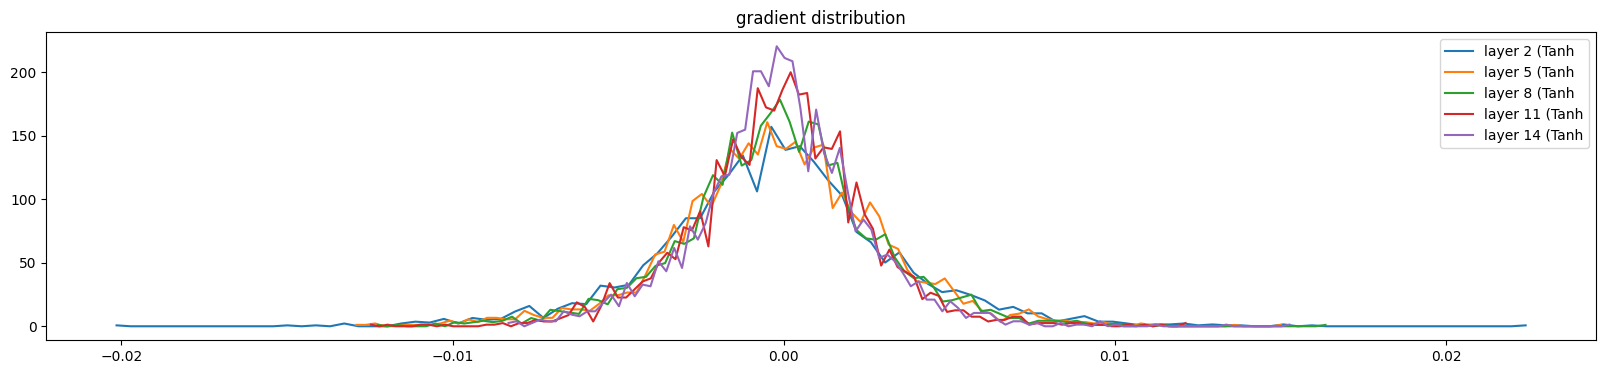

In [37]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.198648e-03 | grad:data ratio 8.190289e-03
weight  (30, 100) | mean -0.000195 | std 7.650391e-03 | grad:data ratio 2.447696e-02
weight (100, 100) | mean -0.000097 | std 6.207569e-03 | grad:data ratio 3.712874e-02
weight (100, 100) | mean +0.000015 | std 5.561918e-03 | grad:data ratio 3.297628e-02
weight (100, 100) | mean +0.000008 | std 5.220600e-03 | grad:data ratio 3.110151e-02
weight (100, 100) | mean +0.000029 | std 4.829159e-03 | grad:data ratio 2.876368e-02
weight  (100, 27) | mean -0.000014 | std 9.281210e-03 | grad:data ratio 5.568814e-02


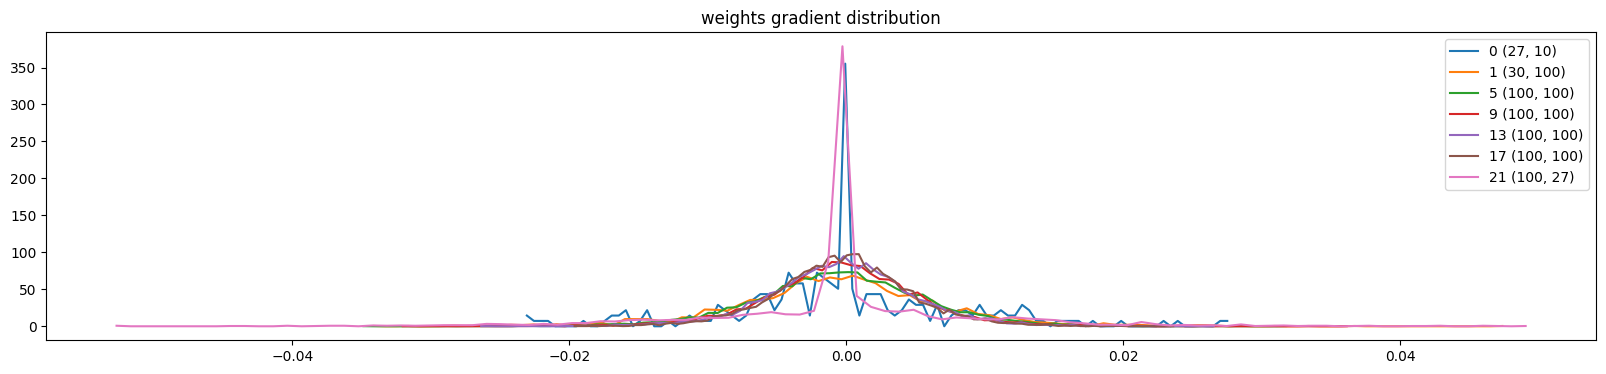

In [38]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

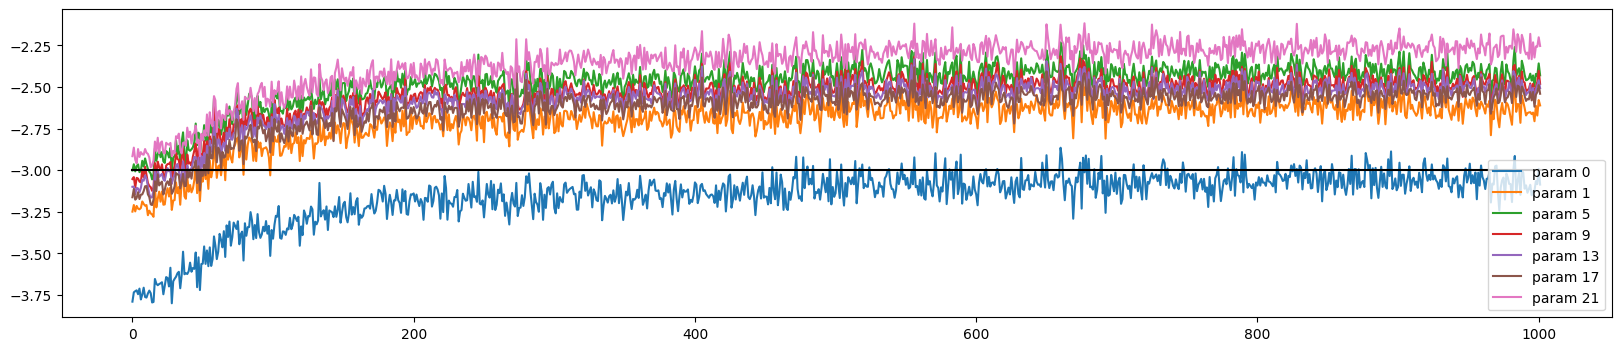

In [39]:

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);